In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [4]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [5]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [6]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

In [7]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [8]:
def neural_style_transfer(imsize, content_filepath, style_filepath,
                          content_layers_default, style_layers_default,
                          trade_off_ratio):
    
    # desired size of the output image
    loader = transforms.Compose([
        transforms.Scale(imsize),  # scale imported image
        transforms.ToTensor()])  # transform it into a torch tensor


    def image_loader(image_name):
        image = Image.open(image_name)
        image = Variable(loader(image))
        # fake batch dimension required to fit network's input dimensions
        image = image.unsqueeze(0)
        return image


    style_img = image_loader(style_filepath).type(dtype)
    content_img = image_loader(content_filepath).type(dtype)

    assert style_img.size() == content_img.size(), \
        "we need to import style and content images of the same size"
        
    unloader = transforms.ToPILImage()  # reconvert into PIL image

    plt.ion()

    def imshow(tensor, title=None):
        image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
        image = image.view(3, imsize, imsize)  # remove the fake batch dimension
        image = unloader(image)
        plt.imshow(image)
        if title is not None:
            plt.title(title)
            plt.pause(0.001) # pause a bit so that plots are updated


    plt.figure()
    imshow(style_img.data, title='Style Image')

    plt.figure()
    imshow(content_img.data, title='Content Image')


    def get_style_model_and_losses(cnn, style_img, content_img,
                                   style_weight= trade_off_ratio, content_weight=1,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        model = nn.Sequential()  # the new Sequential module network
        gram = GramMatrix()  # we need a gram module in order to compute style targets

        # move these modules to the GPU if possible:
        if use_cuda:
            model = model.cuda()
            gram = gram.cuda()

        i = 1
        for layer in list(cnn):
            if isinstance(layer, nn.Conv2d):
                name = "conv_" + str(i)
                model.add_module(name, layer)

                if name in content_layers:
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

                if name in style_layers:
                    # add style loss:
                    target_feature = model(style_img).clone()
                    target_feature_gram = gram(target_feature)
                    style_loss = StyleLoss(target_feature_gram, style_weight)
                    model.add_module("style_loss_" + str(i), style_loss)
                    style_losses.append(style_loss)

            if isinstance(layer, nn.ReLU):
                name = "relu_" + str(i)
                model.add_module(name, layer)

                if name in content_layers:
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

                if name in style_layers:
                    # add style loss:
                    target_feature = model(style_img).clone()
                    target_feature_gram = gram(target_feature)
                    style_loss = StyleLoss(target_feature_gram, style_weight)
                    model.add_module("style_loss_" + str(i), style_loss)
                    style_losses.append(style_loss)

                i += 1

            if isinstance(layer, nn.MaxPool2d):
                name = "pool_" + str(i)
                model.add_module(name, layer)  # ***

        return model, style_losses, content_losses
    
    input_img = content_img.clone()
    # if you want to use a white noise instead uncomment the below line:
    # input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

    # add the original input image to the figure:
    plt.figure()
    imshow(input_img.data, title='Input Image')
    
    def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                           style_weight=trade_off_ratio, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            style_img, content_img, style_weight, content_weight)
        input_param, optimizer = get_input_param_optimizer(input_img)

        print('Optimizing..')
        print()
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values of updated input image
                input_param.data.clamp_(0, 1)

                optimizer.zero_grad()
                model(input_param)
                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.backward()
                for cl in content_losses:
                    content_score += cl.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print()
                    print("For the %0.6f" % run[0] + 'th iteration...')
                    print('Style Loss = {:4f} and Content Loss = {:4f}'.format(style_score.data[0],
                                                                               content_score.data[0]))
                    print()

                return style_score + content_score

            optimizer.step(closure)
            print('Iteration %0.6f' % run[0] + ' is complete!')

        # a last correction...
        input_param.data.clamp_(0, 1)

        return input_param.data
    
    output = run_style_transfer(cnn, content_img, style_img, input_img)

    plt.figure()
    imshow(output, title='Output Image')

    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

Building the style transfer model..
Optimizing..

Iteration 20.000000 is complete!
Iteration 40.000000 is complete!

For the 50.000000th iteration...
Style Loss = 2190.457031 and Content Loss = 1.169596

Iteration 60.000000 is complete!
Iteration 80.000000 is complete!

For the 100.000000th iteration...
Style Loss = 1135.382812 and Content Loss = 1.577157

Iteration 100.000000 is complete!
Iteration 120.000000 is complete!
Iteration 140.000000 is complete!

For the 150.000000th iteration...
Style Loss = 355.929260 and Content Loss = 1.962382

Iteration 160.000000 is complete!
Iteration 180.000000 is complete!

For the 200.000000th iteration...
Style Loss = 97.561432 and Content Loss = 2.232477

Iteration 200.000000 is complete!
Iteration 220.000000 is complete!
Iteration 240.000000 is complete!

For the 250.000000th iteration...
Style Loss = 51.903236 and Content Loss = 2.211568

Iteration 260.000000 is complete!
Iteration 280.000000 is complete!

For the 300.000000th iteration...
Styl

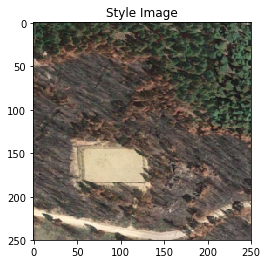

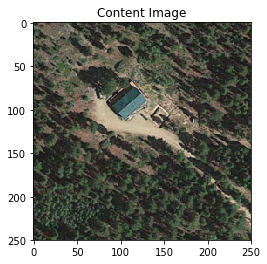

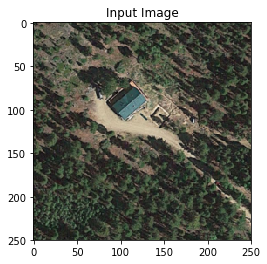

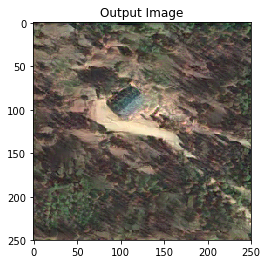

In [9]:
neural_style_transfer(250, "/home/jeremydiaz/INFO4604_Ecosystems/initial_content.jpg",
                      "/home/jeremydiaz/INFO4604_Ecosystems/initial_style.jpg", ['conv_4'],
                      ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'], 10**5)